In [20]:

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
# install requirements
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-oe8tz0ni
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-oe8tz0ni
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [22]:
# create segment anything model predictor
import os

from segment_anything import SamPredictor, sam_model_registry


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


In [38]:
# # load image and select x, y coordinates to test
import cv2

x = 528
y = 606

image = cv2.imread('/content/gdrive/MyDrive/semantic_seg/Anvi.png')

In [39]:
# use sam predictor on (image, x, y) to get location of subject
import numpy as np


predictor.set_image(image)

masks, scores, logits = predictor.predict(
                                  point_coords=np.asarray([[x, y]]),
                                  point_labels=np.asarray([1]),
                                  multimask_output=True
                              )

C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)

for j in range(C):
  result_mask |= masks[j, :, :]

result_mask = result_mask.astype(np.uint8)

In [40]:
# remove background
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

In [41]:
# wrap it up as a function
import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                    point_coords=np.asarray([[x, y]]),
                                    point_labels=np.asarray([1]),
                                    multimask_output=True
                                )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype=bool)

  for j in range(C):
    result_mask |= masks[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64

In [42]:
import matplotlib.pyplot as plt


x = 528
y = 606
image = cv2.imread('/content/gdrive/MyDrive/semantic_seg/Anvi.png')

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

result_image = remove_background(image_bytes_encoded_base64, x, y)

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

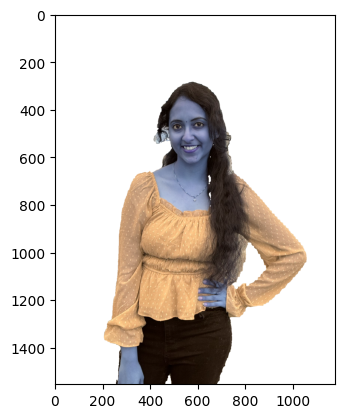

In [43]:
plt.imshow(result_image)
plt.show()

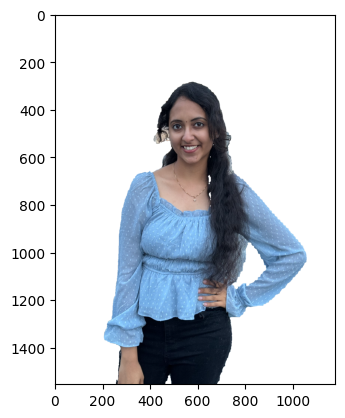

In [44]:
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()